In [53]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import random

True


Print Source Array

In [54]:
import os
import numpy as np
def print_padded_arrays(output_folder):
    count=0
    for root, _, files in os.walk(output_folder):
        #print(files)
        for file in files:
            if file.endswith('.npy'):
                padded_depth_data = np.load(os.path.join(root, file))
                print(f'Array from File: {os.path.join(root, file)}\n', padded_depth_data)
                print(f'Shape: {padded_depth_data.shape}\n')
                #print(file)
                #print(count)
                count+=1

    print(count)

if __name__ == "__main__":
    output_folder = "../padded_depth_numpy_center/"  # Replace with the actual output folder path
    print_padded_arrays(output_folder)

Array from File: ../padded_depth_numpy_center/007/007_11_depth_data.npy
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape: (158, 155)

Array from File: ../padded_depth_numpy_center/007/007_02_depth_data.npy
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape: (158, 155)

Array from File: ../padded_depth_numpy_center/007/007_09_depth_data.npy
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape: (158, 155)

Array from File: ../padded_depth_numpy_center/007/007_01_depth_data.npy
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape: (158, 155)

Array fr

In [55]:
def extract_file_id(full_path):
    segments = full_path.split(os.sep)
    return os.sep.join(segments[-2:])

class SiameseNetworkDataset(Dataset):
    def __init__(self, data_folder, file_list, transform=None):
        self.folder_path = data_folder
        self.file_list = file_list
        self.transform = transform
        
        # Populate the list of available npy files
        for person_folder in os.listdir(data_folder):
            person_path = os.path.join(data_folder, person_folder)
            for file in os.listdir(person_path):
                file_path = os.path.join(person_path, file)
                self.file_list.append((file_path, person_folder))
        #print(self.file_list)
    
    def load_npy_file(self, path):
        return np.load(path)

    def __getitem__(self, index):
        file0_tuple = random.choice(self.file_list)
        
        # 50% chance to get same or different class
        should_get_same_class = random.randint(0, 1)
        
        if should_get_same_class:
            # Find another file from the same person
            while True:
                file1_tuple = random.choice(self.file_list)
                if file0_tuple[1] == file1_tuple[1]:
                    break
        else:
            # Find another file from a different person
            while True:
                file1_tuple = random.choice(self.file_list)
                if file0_tuple[1] != file1_tuple[1]:
                    break
        #print("Comparing {} with {} - Label: {}".format(file0_tuple[0], file1_tuple[0], int(file0_tuple[1] != file1_tuple[1])))

        # Load npy files
        data0 = self.load_npy_file(file0_tuple[0])
        data1 = self.load_npy_file(file1_tuple[0])
        

        data0 = np.expand_dims(data0, axis=0)
        data1 = np.expand_dims(data1, axis=0)

        file0_id = extract_file_id(file0_tuple[0])
        file1_id = extract_file_id(file1_tuple[0])

        # If you have a transform, apply it
        if self.transform:
            data0 = self.transform(data0)
            data1 = self.transform(data1)

        file0_id = extract_file_id(file0_tuple[0])
        file1_id = extract_file_id(file1_tuple[0])
        

        #print("data0: ",data0, " data1: ", data1)
        # Return data and a label indicating whether the files are from the same class or not
        return torch.from_numpy(data0), torch.from_numpy(data1), torch.from_numpy(np.array([int(file1_tuple[1] != file0_tuple[1])], dtype=np.float32)), file0_id, file1_id

    def __len__(self):
        return len(self.file_list)

In [56]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [57]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(9600, 1024),  # Change this line
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256,2)
        )


    def forward_one(self, x):
        x = self.cnn1(x)
        #print("Shape of x after cnn1:", x.shape)  # Add this line for debugging
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [67]:
from sklearn.model_selection import train_test_split


train_folder_path = '../padded_depth_numpy_center/'
#test_folder_path = '../test1_depth_numpy'


all_files = [f for f in os.listdir(train_folder_path) if f.endswith('.npy')]
for person_folder in os.listdir(train_folder_path):
    person_path = os.path.join(train_folder_path, person_folder)
    for file in os.listdir(person_path):
        file_path = os.path.join(person_path, file)
        all_files.append((file_path, person_folder))

train_siamese_dataset = SiameseNetworkDataset(train_folder_path, all_files)
train_dataloader = DataLoader(train_siamese_dataset, shuffle=True, num_workers=8, batch_size=64)


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.00001)  # Reduce the learning rate

error_array=[]
valid_error_array=[]

for epoch in range(800):
    for i, (array1, array2, label, file0, file1) in enumerate(train_dataloader, 0):

        array1, array2, label = array1.float().cuda(), array2.float().cuda(), label.float().cuda()
        #print(array1.shape)
        if torch.isnan(array1).any() or torch.isinf(array1).any():
            print("NaN or inf in array1")
        
        if torch.isnan(array2).any() or torch.isinf(array2).any():
            print("NaN or inf in array2")

        optimizer.zero_grad()
        output1, output2 = net(array1, array2)
        
        if torch.isnan(output1).any() or torch.isnan(output2).any():
            print("NaN in outputs")

        loss = criterion(output1, output2, label)
        
        if torch.isnan(loss):
            print("Loss is NaN. Stopping the training.")
            exit()
            
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")
    error_array.append(loss.item())

model_filepath = 'simese.pth'
torch.save(net.state_dict(), model_filepath)
print(f"Model saved at {model_filepath}")
print('\n')


Epoch: 0, Batch: 0, Loss: 2.056650161743164
Epoch: 1, Batch: 0, Loss: 2.186544418334961
Epoch: 2, Batch: 0, Loss: 1.4038119316101074
Epoch: 3, Batch: 0, Loss: 1.5668469667434692
Epoch: 4, Batch: 0, Loss: 1.4895732402801514
Epoch: 5, Batch: 0, Loss: 1.127898931503296
Epoch: 6, Batch: 0, Loss: 0.9267432689666748
Epoch: 7, Batch: 0, Loss: 0.5691278576850891
Epoch: 8, Batch: 0, Loss: 0.7980765104293823
Epoch: 9, Batch: 0, Loss: 0.6888337135314941
Epoch: 10, Batch: 0, Loss: 0.6302077174186707
Epoch: 11, Batch: 0, Loss: 0.7684937715530396
Epoch: 12, Batch: 0, Loss: 0.789466142654419
Epoch: 13, Batch: 0, Loss: 0.9270729422569275
Epoch: 14, Batch: 0, Loss: 0.6226601600646973
Epoch: 15, Batch: 0, Loss: 0.8150297403335571
Epoch: 16, Batch: 0, Loss: 0.9343393445014954
Epoch: 17, Batch: 0, Loss: 0.852526068687439
Epoch: 18, Batch: 0, Loss: 0.6759844422340393
Epoch: 19, Batch: 0, Loss: 0.5058227777481079
Epoch: 20, Batch: 0, Loss: 0.6188273429870605
Epoch: 21, Batch: 0, Loss: 0.6112578511238098
Epo

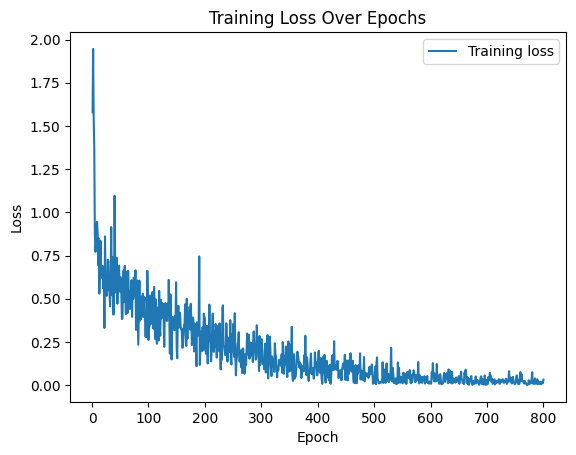

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random training and validation errors for 500 epochs
# Plot the training and validation error against epochs
plt.figure()
plt.plot(range(1, len(error_array) + 1), error_array, label='Training loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()